In [1]:
import pandas as pd
import numpy as np
import warnings 
warnings.simplefilter('ignore')
import torchviz
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import joblib
import os
from sklearn.preprocessing import StandardScaler
import time
def get_col(df,name):
    return df.columns[df.columns.str.contains(name)].tolist()
os.listdir('./data')

['PA_201605-2012001更新R7(20200323).xlsx',
 'pred_0997_all.csv',
 'tag盤點表20200323.xlsx',
 'tag盤點表_cleaned.csv',
 'train_cleaned.csv',
 'train_preprocessed']

In [2]:
tag = pd.read_csv('./data/tag盤點表_cleaned.csv',index_col=0)
tag = tag.loc[tag.category=='可控制因子']

# load X,y

In [3]:
# 2016-05 : 2017-02-17 第一段

In [4]:
data = joblib.load('./data/train_preprocessed')
X = data['X']
Y = data['Y']
x_col = data['x_col']
y_col = data['y_col']
idx = data['idx']
# build df
df = pd.DataFrame(X,index=idx)
df['0997_real'] = Y
df.head()

,0,1,2,3,4,5,6,7,8,9,...,509,510,511,512,513,514,515,516,517,0997_real
2016-06-01 02:20:00,5695.2363,85.352490,36.090110,34.696857,49.382782,362.26434,144.97864,2.442607,361.02557,60.061237,...,362.24190,145.08502,2.402832,361.04126,61.009296,184.70750,180.05136,364.76276,182.63521,6439.8774
2016-06-01 02:30:00,5709.7036,85.653360,35.959490,35.388890,49.400085,362.33936,144.83496,2.486111,361.09380,60.353172,...,362.15997,144.98183,2.287988,361.01490,60.147133,184.69267,179.98978,364.76007,182.65807,6459.6940
2016-06-01 02:40:00,5687.0700,85.301930,36.018215,34.879738,49.394993,362.22006,145.24248,2.369419,361.02510,61.337530,...,362.18622,144.94327,2.347922,361.01324,60.350594,184.75967,180.01015,364.79498,179.32439,6467.7600
2016-06-01 02:50:00,5689.3900,85.273994,35.984818,35.051820,49.394978,362.19617,145.12143,2.425157,360.96103,60.153100,...,362.19500,145.05249,2.342792,361.01670,60.989777,184.67749,180.01030,364.68997,181.94745,6450.8740
2016-06-01 03:00:00,5695.1797,85.347840,36.002686,34.899242,49.394980,362.21060,144.92728,2.340548,361.02005,60.312088,...,362.24260,144.96265,2.392348,361.03952,60.260216,184.69803,179.80000,364.90765,182.75210,6443.6900


# select data range

In [5]:
df = df.loc['2016-05':'2017-02-17']
idx = df.index
df.head(3).append(df.tail(3))

,0,1,2,3,4,5,6,7,8,9,...,509,510,511,512,513,514,515,516,517,0997_real
2016-06-01 02:20:00,5695.2363,85.352490,36.090110,34.696857,49.382782,362.26434,144.97864,2.442607,361.02557,60.061237,...,362.24190,145.08502,2.402832,361.04126,61.009296,184.70750,180.05136,364.76276,182.63521,6439.8774
2016-06-01 02:30:00,5709.7036,85.653360,35.959490,35.388890,49.400085,362.33936,144.83496,2.486111,361.09380,60.353172,...,362.15997,144.98183,2.287988,361.01490,60.147133,184.69267,179.98978,364.76007,182.65807,6459.6940
2016-06-01 02:40:00,5687.0700,85.301930,36.018215,34.879738,49.394993,362.22006,145.24248,2.369419,361.02510,61.337530,...,362.18622,144.94327,2.347922,361.01324,60.350594,184.75967,180.01015,364.79498,179.32439,6467.7600
2017-02-17 06:00:00,7306.1675,76.976906,35.855827,34.771680,49.489944,346.97110,146.52061,1.665420,346.13565,60.293194,...,346.95000,146.57059,1.660524,346.11940,60.531060,181.40356,171.90000,351.18213,177.66031,8041.7900
2017-02-17 06:10:00,7311.0150,77.024400,36.149185,34.781406,49.500084,346.94608,146.55403,1.605125,346.13104,60.636740,...,346.66315,146.53949,1.471631,345.91745,60.654694,181.55270,171.80660,351.08212,174.84160,8039.3890
2017-02-17 06:20:00,7317.4663,77.056725,35.699017,35.596460,49.492065,347.00330,146.23785,1.693551,346.15933,60.640736,...,345.78055,146.76909,0.466979,345.54070,60.545030,182.09363,171.79341,350.99005,178.14595,8021.1885


# split train test

In [6]:
X = df.iloc[:,:-1]
Y = df.iloc[:,-1:]

In [7]:
sp1 = int(len(X)*0.7)
sp2 = int(len(X)*0.85)
X_train,X_valid,X_test = X[:sp1],X[sp1:sp2],X[sp2:]
Y_train,Y_valid,Y_test = Y[:sp1],Y[sp1:sp2],Y[sp2:]
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(23946, 518)
(23946, 1)
(5131, 518)
(5131, 1)
(5132, 518)
(5132, 1)


# plot

In [8]:
t1 = df.iloc[[sp1]].index[0]
t2 = df.iloc[[sp2]].index[0]

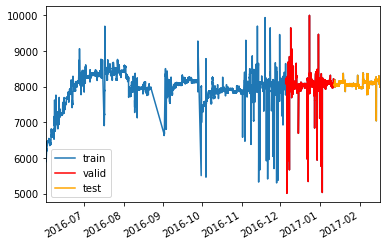

In [9]:
df['0997_real'].plot(label='train')
df['0997_real'][(df.index > t1)&(df.index < t2)].plot(color = 'red',label='valid')
df['0997_real'][(df.index > t2)].plot(color = 'orange',label='test')
plt.legend()
plt.show()

# MinMaxScaler

In [10]:
from sklearn.preprocessing import MinMaxScaler
mm_x = MinMaxScaler().fit(X)
mm_y = MinMaxScaler().fit(Y)

In [11]:
joblib.dump(mm_x,'./model/mm_x.pkl')
joblib.dump(mm_y,'./model/mm_y.pkl')
print('save done!')

save done!


# scale 

In [12]:
X_train = mm_x.transform(X_train)
X_valid = mm_x.transform(X_valid)
X_test = mm_x.transform(X_test)

Y_train = mm_y.transform(Y_train)
Y_valid = mm_y.transform(Y_valid)
Y_test = mm_y.transform(Y_test)

# torch tensor

In [13]:
import torch

X_train = torch.tensor(X_train).cuda()
X_test = torch.tensor(X_test).cuda()

X_valid = torch.tensor(X_valid).cuda()
Y_valid = torch.tensor(Y_valid).cuda()

Y_train = torch.tensor(Y_train).cuda()
Y_test = torch.tensor(Y_test).cuda()

# data_iter

In [14]:
train = torch.utils.data.TensorDataset(X_train, Y_train)
valid = torch.utils.data.TensorDataset(X_valid, Y_valid)
train_iter = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)
valid_iter = torch.utils.data.DataLoader(valid, batch_size=256, shuffle=True)

# Construct the neural network

In [15]:
class Net(nn.Module):
    def __init__(self,input_shape,output_shape):
        super(Net,self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_shape,128),nn.Tanh(),
            nn.Linear(128,128),nn.Tanh(),
            nn.Dropout(0.25),
            nn.Linear(128,output_shape),
            nn.Sigmoid(),# 將range限縮在[0,1]
        )

    def forward(self, x):
        return self.fc(x)

In [16]:
def init_weights(m):
    if hasattr(m,'weight'):
        torch.nn.init.xavier_uniform(m.weight)
    if hasattr(m,'bias'):
        m.bias.data.fill_(0)

In [17]:
net = Net(X_train.shape[1],Y_train.shape[1]).cuda().double()
net.apply(init_weights)

Net(
  (fc): Sequential(
    (0): Linear(in_features=518, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Dropout(p=0.25, inplace=False)
    (5): Linear(in_features=128, out_features=1, bias=True)
    (6): Sigmoid()
  )
)

# tensorboard

In [18]:
#with SummaryWriter(comment='Net')as w:
#    w.add_graph(net, (X_test,))

# torchviz

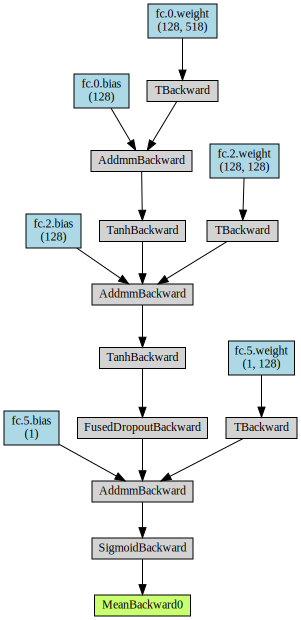

In [19]:
torchviz.make_dot(net(X_test).mean(),params=dict(net.named_parameters()))

# loss_function and optimizer

In [20]:
optimizer = torch.optim.Adam(net.parameters(),lr=1e-4)
loss_function = nn.MSELoss()

# Training and evaluation

In [21]:
def train(net,train_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    for epoch in range(num_epochs): 
        
        # train model
        net.train()
        train_loss,i = 0,0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
            i += 1
        
        # eval model
        with torch.no_grad():
            net.eval()
            val_loss,j = 0,0
            for x, y in valid_iter:
                loss = loss_function(net(x),y)
                val_loss += loss.item()
                j += 1
        
        # caculate avg loss
        train_avg_loss = train_loss/i
        val_avg_loss = val_loss/j
        
        # save the best model
        if val_avg_loss <= best_loss:
            best_loss = val_avg_loss
            joblib.dump(net,'./model/net.pkl')
            print('model saved')
        
        # record history and print loss of the epoch
        train_history.append(train_avg_loss)
        valid_history.append(val_avg_loss)
        print("epochs {} train_avg_loss {:.4f} valid_avg_loss {:.4f}".format(epoch,train_avg_loss,val_avg_loss))
        
    # plot result
    print('best val_avg_loss is ',best_loss)
    fig = plt.figure(figsize=(20,5))
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.legend()
    plt.title('loss')
    plt.show()
    print('model save at ./model/net.pkl')

model saved
epochs 0 train_avg_loss 0.0068 valid_avg_loss 0.0016
epochs 1 train_avg_loss 0.0020 valid_avg_loss 0.0016
model saved
epochs 2 train_avg_loss 0.0016 valid_avg_loss 0.0016
model saved
epochs 3 train_avg_loss 0.0014 valid_avg_loss 0.0016
model saved
epochs 4 train_avg_loss 0.0013 valid_avg_loss 0.0015
epochs 5 train_avg_loss 0.0013 valid_avg_loss 0.0015
epochs 6 train_avg_loss 0.0013 valid_avg_loss 0.0018
epochs 7 train_avg_loss 0.0012 valid_avg_loss 0.0016
epochs 8 train_avg_loss 0.0012 valid_avg_loss 0.0017
epochs 9 train_avg_loss 0.0012 valid_avg_loss 0.0018
best val_avg_loss is  0.0014842217078546774


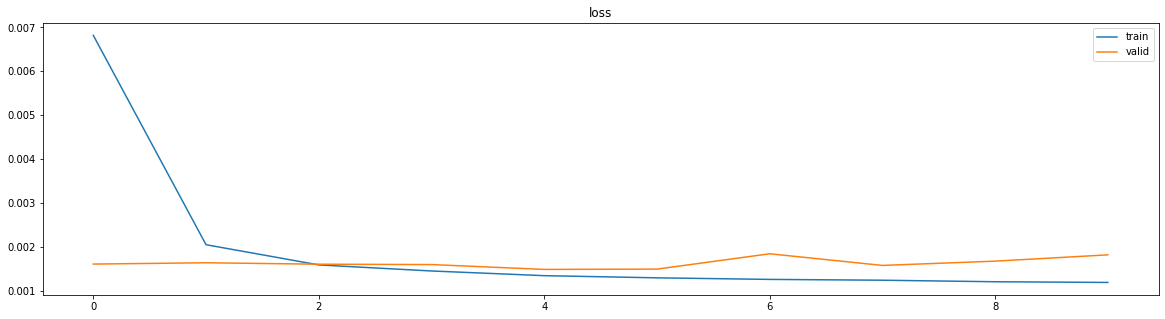

model save at ./model/net.pkl
15.532552242279053


In [22]:
s = time.time()
train(net,train_iter,loss_function,optimizer,num_epochs=10)
print(time.time()-s)

# load best net

In [23]:
net = joblib.load('./model/net.pkl')
net = net.eval()
net

Net(
  (fc): Sequential(
    (0): Linear(in_features=518, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Dropout(p=0.25, inplace=False)
    (5): Linear(in_features=128, out_features=1, bias=True)
    (6): Sigmoid()
  )
)

# metrics

In [24]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from math import sqrt

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))


feed = X.values.reshape(-1,37,14).mean(axis=1)
feed = pd.DataFrame(feed,columns=x_col,index=idx)
feed = feed['MLPAP_FQ-0619.PV']

def show_result(X,Y,index):
    t = pd.DataFrame(index=index)
    t['0619'] = feed[index]
    t['0997_real'] = mm_y.inverse_transform(Y.detach().cpu().numpy().reshape(-1,1)).ravel()
    t['0997_pred'] = mm_y.inverse_transform(net(X).detach().cpu().numpy().reshape(-1,1)).ravel()
    t['單耗_real'] = t['0619']/t['0997_real']
    t['單耗_pred'] = t['0619']/t['0997_pred']
    t['0997_R2'] = r2_score(t['0997_real'],t['0997_pred'])
    t['0997_MAPE'] = mape(t['0997_real'],t['0997_pred'])
    t['單耗RMSE'] = sqrt(mean_squared_error(t['單耗_real'],t['單耗_pred']))
    return t

# make prediction(train)

In [25]:
t1 = show_result(X_train,Y_train,idx[:sp1])
print('0997_real標準差',df.iloc[:sp1]['0997_real'].std())
t1.head()

0997_real標準差 399.76604140195616


,0619,0997_real,0997_pred,單耗_real,單耗_pred,0997_R2,0997_MAPE,單耗RMSE
2016-06-01 02:20:00,5694.183976,6439.8774,6329.777069,0.884207,0.899587,0.833556,0.01338,0.019743
2016-06-01 02:30:00,5694.205724,6459.6940,6327.509777,0.881498,0.899913,0.833556,0.01338,0.019743
2016-06-01 02:40:00,5693.698811,6467.7600,6345.219356,0.880320,0.897321,0.833556,0.01338,0.019743
2016-06-01 02:50:00,5693.984649,6450.8740,6327.728283,0.882669,0.899847,0.833556,0.01338,0.019743
2016-06-01 03:00:00,5694.179676,6443.6900,6348.062912,0.883683,0.896995,0.833556,0.01338,0.019743


# make prediction(valid)

In [26]:
t2 = show_result(X_valid,Y_valid,idx[sp1:sp2])
print('0997_real標準差',df.iloc[sp1:sp2]['0997_real'].std())
t2.head()

0997_real標準差 194.4049143211722


,0619,0997_real,0997_pred,單耗_real,單耗_pred,0997_R2,0997_MAPE,單耗RMSE
2016-12-05 09:10:00,7294.562630,8179.2583,8084.396274,0.891837,0.902301,-0.020072,0.012084,0.027297
2016-12-05 09:20:00,7294.360668,8192.6360,8060.435576,0.890356,0.904959,-0.020072,0.012084,0.027297
2016-12-05 09:30:00,7294.114411,8196.8890,8059.174037,0.889864,0.905070,-0.020072,0.012084,0.027297
2016-12-05 09:40:00,7293.696941,8204.8670,8003.565738,0.888948,0.911306,-0.020072,0.012084,0.027297
2016-12-05 09:50:00,7293.472135,8075.9126,8029.261613,0.903114,0.908362,-0.020072,0.012084,0.027297


# make prediction(test)

In [27]:
t3 = show_result(X_test,Y_test,idx[sp2:])
print('0997_real標準差',df.iloc[sp2:]['0997_real'].std())
t3.head()

0997_real標準差 69.84749286555892


,0619,0997_real,0997_pred,單耗_real,單耗_pred,0997_R2,0997_MAPE,單耗RMSE
2017-01-12 08:50:00,7299.433195,8053.5490,8055.423645,0.906362,0.906151,-0.141814,0.006814,0.008375
2017-01-12 09:00:00,7299.846932,8050.2944,8081.418091,0.906780,0.903288,-0.141814,0.006814,0.008375
2017-01-12 09:10:00,7300.196662,8043.0327,8149.892278,0.907642,0.895741,-0.141814,0.006814,0.008375
2017-01-12 09:20:00,7300.776519,8040.0903,8063.120861,0.908047,0.905453,-0.141814,0.006814,0.008375
2017-01-12 09:30:00,7301.300438,8049.6143,8137.892174,0.907037,0.897198,-0.141814,0.006814,0.008375


# 標準差跟R2是有關係的 數據變異太少 太穩定 標準差低 則R2也高不起來

In [28]:
pred_0997_all = t1.append(t2).append(t3)['0997_pred']
pred_0997_all.head()

2016-06-01 02:20:00    6329.777069
2016-06-01 02:30:00    6327.509777
2016-06-01 02:40:00    6345.219356
2016-06-01 02:50:00    6327.728283
2016-06-01 03:00:00    6348.062912
Name: 0997_pred, dtype: float64

In [29]:
pred_0997_all.to_csv('./data/pred_0997_all.csv')
print('save done')

save done
